TIR
Baseline MSE -  999.67926  Unet MSE -  532.1717 Improvement -  46.765756472794465
Baseline MAE -  17.693218  UNet MAE -  14.256776 Improvement -  19.422370369699607


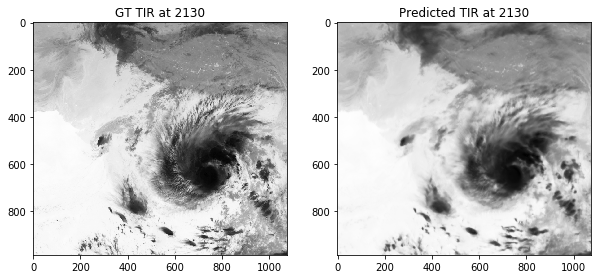

Baseline MSE -  975.7968  Unet MSE -  504.12006 Improvement -  48.3375996992642
Baseline MAE -  17.80501  UNet MAE -  14.179909 Improvement -  20.360006097513292


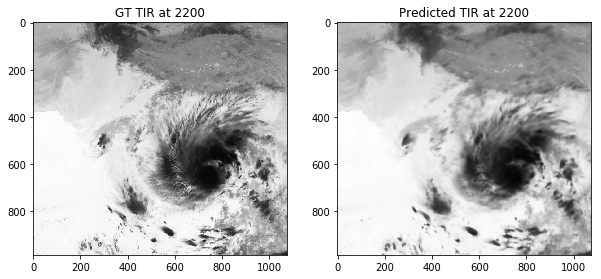

Baseline MSE -  1081.2587  Unet MSE -  582.03955 Improvement -  46.1701840133823
Baseline MAE -  18.96843  UNet MAE -  14.819237 Improvement -  21.874203110733923


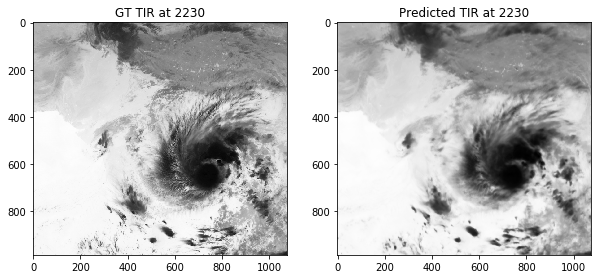

Baseline MSE -  931.7631  Unet MSE -  578.20984 Improvement -  37.944545682443355
Baseline MAE -  17.740675  UNet MAE -  15.048055 Improvement -  15.177665345729267


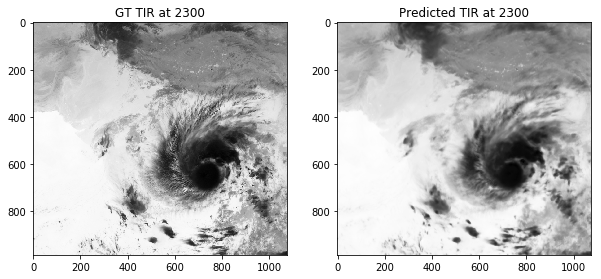

Baseline MSE -  1020.4121  Unet MSE -  532.2202 Improvement -  47.84262064767796
Baseline MAE -  18.510008  UNet MAE -  14.388066 Improvement -  22.268718619826217


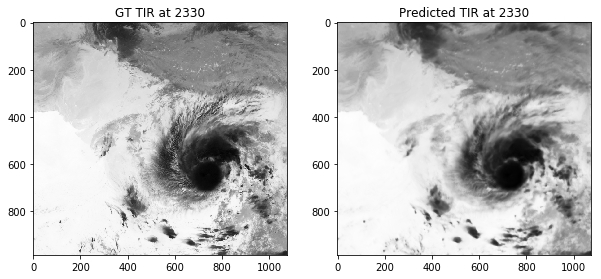

VIS
Baseline MSE -  1718.8212  Unet MSE -  1815.862 Improvement -  -5.645781854345094
Baseline MAE -  23.162752  UNet MAE -  28.888838 Improvement -  -24.72109369988504


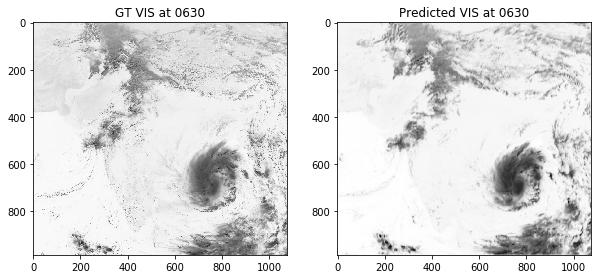

Baseline MSE -  1757.1769  Unet MSE -  1860.4384 Improvement -  -5.876555501701206
Baseline MAE -  24.134434  UNet MAE -  28.896229 Improvement -  -19.730295286782344


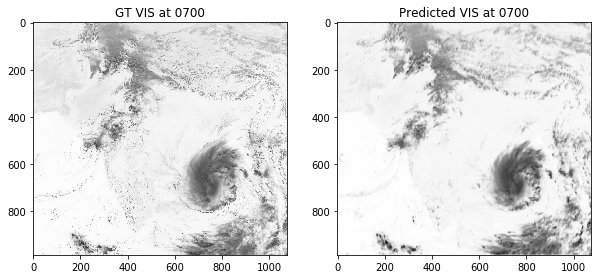

Baseline MSE -  1616.449  Unet MSE -  1699.8954 Improvement -  -5.162328811089001
Baseline MAE -  23.202412  UNet MAE -  27.370905 Improvement -  -17.965775857547705


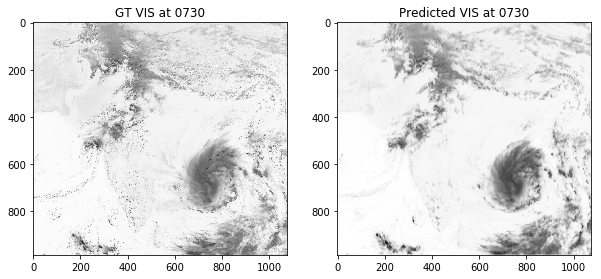

Baseline MSE -  1850.8038  Unet MSE -  1711.5911 Improvement -  7.521746285150462
Baseline MAE -  25.88169  UNet MAE -  27.036842 Improvement -  -4.463206676109932


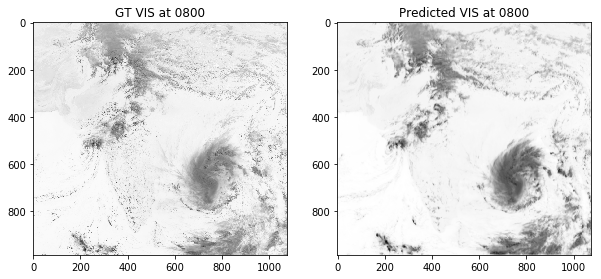

Baseline MSE -  1578.8099  Unet MSE -  1525.7233 Improvement -  3.3624484299087083
Baseline MAE -  24.11013  UNet MAE -  25.037008 Improvement -  -3.8443507502619325


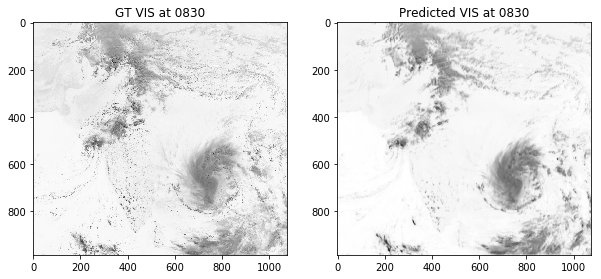

In [3]:
import numpy as np
from PIL import Image
import torch
import os
import matplotlib.pyplot as plt
%matplotlib inline

import sys
from pre_processing import get_seq_data


dir_paths = ["./INSAT3D_TIR1_India", "./INSAT3D_VIS_India" ]
print_format = ['TIR','VIS']

inp_seq = 3
pred_frame = 1

# for final output
last_sequence = [ ['3DIMG_07NOV2019_2230_L1C_SGP.tif','3DIMG_07NOV2019_2300_L1C_SGP.tif','3DIMG_07NOV2019_2330_L1C_SGP.tif'],
                    ['3DIMG_07NOV2019_2230_L1C_SGP_vis.tif','3DIMG_07NOV2019_2300_L1C_SGP_vis.tif','3DIMG_07NOV2019_2330_L1C_SGP_vis.tif'] ]



# values calculated on training set
mn,mx = 387.0, 948.0
vmean, vstd = 68.5147950474417, 71.67788656008055

model_paths = ["./tir_inp3_ds4_stand.ckpt", "./vis_inp3_1.ckpt"]
device = torch.device('cuda:2' if torch.cuda.is_available() else 'cpu')
    



def pre_process(inp,iformat = 'TIR'):
    
    if( iformat=='TIR' ):
        inp = (inp-mn)/(mx-mn)
    else:
        inp = (inp-vmean)/vstd
        
    inp = np.expand_dims(inp,axis=0)
    inp = torch.from_numpy(inp)
    inp = inp.to(device,dtype=torch.float)

    return inp

def post_process(inp,iformat='TIR'):

    if( iformat=='TIR' ):
        inp = inp*(mx-mn) + mn
    else:
        inp = inp*vstd + vmean
    inp = inp.detach().numpy()
    inp = np.squeeze(inp)[:984,:1074]
    return inp


for i,dir_path in enumerate(dir_paths):
    inp,target = get_seq_data( dir_path )
    if print_format[i] == 'TIR':
        inp,target = inp[-5:], target[-5:]
    else:
        inp, target = inp[10:15], target[10:15]
    print(print_format[i])
    model = torch.load(model_paths[i],map_location=device)
    model = model.to(device)
    model.eval() 

    for k in range( len(target) ):
        # get images in numpy array
        img,gt = [],[]
        for j in range(inp_seq):
            img.append( np.array(Image.open(  inp[k][j] ) ) ) 
            #print(inp[k][j])

        gt = np.array( Image.open(target[k][0]) ) 
        latest = np.array( Image.open(   inp[k][-1] ) )    # most recent image for prediction at 2330              
        #print(target[k][0])

        img, gt = np.array(img), np.array(gt)
        img = pre_process(img,print_format[i])

        output = model(img).cpu()    
        output = post_process(output,iformat=print_format[i])

        unet_mse = ((output-gt)**2).mean()
        unet_mae =  np.abs( output-gt).mean() 

        bmse = ((latest-gt)**2).mean()
        bmae = np.abs(latest-gt).mean()
        
        print( "Baseline MSE - ", bmse, " Unet MSE - ", unet_mse, "Improvement - ", (bmse-unet_mse)*100/bmse, "%" )
        print( "Baseline MAE - ", bmae, " UNet MAE - ", unet_mae , "Improvement - ", (bmae-unet_mae)*100/bmae, "%")
       
        Image.fromarray( np.squeeze(output) ).save( f"{print_format[i]}_results/unet_pred_{target[k][0][target[k][0].rfind('/')+1:]}_{print_format[i]}.tif" )
        fig = plt.figure(figsize=(10,10))
        ax = fig.add_subplot(1, 2, 1)
        plt.imshow(gt,cmap='Greys')
        tind = -16 if print_format[i]=='TIR' else -20                                           
        ax.set_title(f"GT {print_format[i]} at {target[k][0][tind:tind+4]}")
        ax = fig.add_subplot(1, 2, 2)
        plt.imshow(np.squeeze(output),cmap='Greys')
        ax.set_title(f"Predicted {print_format[i]} at {target[k][0][tind:tind+4]}" )
    
        plt.show()

    

In [2]:
from IPython.display import HTML, display

In [3]:

display(HTML("<table><tr><td><img src='gt_tir_ff.gif'></td><td><img src='pred_tir_ff.gif'></td></tr></table>"))

,
